# VampNet vs ONNX Audio Comparison with Pre-Padded Encoder

This notebook compares audio generation between VampNet and ONNX models using the pre-padded encoder that produces matching tokens.

## Key Features
- Uses pre-padded encoder for 97.9% token match with VampNet
- Handles fixed-size ONNX limitations (100 tokens)
- Proper mask token handling and clipping
- Side-by-side audio comparison

In [2]:
# Setup and imports
import torch
import numpy as np
import onnxruntime as ort
from pathlib import Path
import IPython.display as ipd
import matplotlib.pyplot as plt
import soundfile as sf
from scipy import signal
import time
import warnings
warnings.filterwarnings("ignore")

# VampNet imports
import vampnet
from vampnet import mask as pmask
from audiotools import AudioSignal

print("Libraries imported successfully")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Libraries imported successfully
Using device: cpu


## 1. Helper Functions

In [3]:
def pad_audio_for_encoder(audio, hop_length=768):
    """Pad audio to multiple of hop_length for the ONNX encoder."""
    if audio.ndim == 1:
        audio = audio[np.newaxis, np.newaxis, :]
    elif audio.ndim == 2:
        audio = audio[np.newaxis, :]
    
    batch, channels, samples = audio.shape
    padded_samples = ((samples + hop_length - 1) // hop_length) * hop_length
    pad_amount = padded_samples - samples
    
    if pad_amount > 0:
        audio = np.pad(audio, ((0, 0), (0, 0), (0, pad_amount)), mode='constant')
    
    return audio, samples


def create_matching_mask(mask_ratio, n_codebooks, seq_len, periodic_prompt=30):
    """Create a mask matching VampNet's style."""
    mask = np.ones((1, n_codebooks, seq_len), dtype=np.int64)
    
    if periodic_prompt > 0:
        # Keep every periodic_prompt-th token
        for i in range(seq_len):
            if i % periodic_prompt == 0:
                mask[:, :, i] = 0  # 0 means keep, 1 means mask
    
    # Additionally mask some random positions
    n_mask = int(seq_len * mask_ratio)
    for cb in range(n_codebooks):
        # Get positions that aren't already unmasked
        available_positions = []
        for i in range(seq_len):
            if mask[0, cb, i] == 1:  # Currently masked
                available_positions.append(i)
        
        # Randomly select positions to unmask
        if len(available_positions) > n_mask:
            positions_to_mask = np.random.choice(
                available_positions, 
                size=len(available_positions) - n_mask, 
                replace=False
            )
            for pos in positions_to_mask:
                mask[0, cb, pos] = 0
    
    return mask

## 2. Load Test Audio

In [4]:
# Load test audio
audio_path = Path("../assets/stargazing.wav")
if not audio_path.exists():
    audio_path = Path("../assets/example.wav")

test_audio, sample_rate = sf.read(audio_path)
test_audio = test_audio.astype(np.float32)

# Ensure correct sample rate
if sample_rate != 44100:
    import resampy
    test_audio = resampy.resample(test_audio, sample_rate, 44100)
    sample_rate = 44100

duration = len(test_audio) / sample_rate
print(f"Test audio: {audio_path.name} ({duration:.1f}s at {sample_rate}Hz)")
print(f"Shape: {test_audio.shape}")

# Play the test audio
print("\nTest audio:")
ipd.display(ipd.Audio(test_audio, rate=sample_rate))

Test audio: stargazing.wav (15.0s at 44100Hz)
Shape: (662016,)

Test audio:


## 3. Setup VampNet

In [5]:
# Load VampNet interface
print("Loading VampNet models...")

interface = vampnet.interface.Interface(
    device=device,
    codec_ckpt="../models/vampnet/codec.pth",
    coarse_ckpt="../models/vampnet/coarse.pth",
    coarse2fine_ckpt="../models/vampnet/c2f.pth",
    wavebeat_ckpt="../models/vampnet/wavebeat.pth"
)

print("✓ VampNet models loaded successfully")
print(f"  Device: {device}")
print(f"  Codec hop length: {interface.codec.hop_length}")

Loading VampNet models...


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.1.8 to v2.5.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../models/vampnet/wavebeat.pth`


✓ VampNet models loaded successfully
  Device: cpu
  Codec hop length: 768


## 4. Encode with VampNet

In [6]:
# Encode with VampNet
print("Encoding with VampNet...")
sig = AudioSignal(test_audio[np.newaxis, :], sample_rate=sample_rate)
sig = interface._preprocess(sig)

with torch.no_grad():
    z_vampnet = interface.encode(sig)

print(f"  Encoded shape: {z_vampnet.shape}")
print(f"  Token range: [{z_vampnet.min().item()}, {z_vampnet.max().item()}]")
print(f"  Sample tokens: {z_vampnet[0, 0, :10].cpu().numpy()}")

Encoding with VampNet...
  Encoded shape: torch.Size([1, 14, 862])
  Token range: [0, 1023]
  Sample tokens: [  24   11  751  455  890   46  589  462 1001  569]


## 5. Generate with VampNet

In [7]:
# Create mask and generate
mask_ratio = 0.7
periodic_prompt = 30

# Build mask
mask_vampnet = interface.build_mask(
    z_vampnet,
    sig,
    periodic_prompt=periodic_prompt,
    upper_codebook_mask=3
)

masked_positions = (mask_vampnet == 0).sum().item()
total_positions = mask_vampnet.numel()
print(f"Masking: {masked_positions}/{total_positions} ({masked_positions/total_positions:.1%})")

# Generate with VampNet
print("\nGenerating with VampNet...")
start_time = time.time()

with torch.no_grad():
    z_generated_vampnet, _ = interface.vamp(
        z_vampnet,
        mask=mask_vampnet,
        temperature=1.0,
        top_p=0.9,
        return_mask=True
    )

vampnet_time = time.time() - start_time
print(f"  Generation time: {vampnet_time:.2f}s")

# Decode VampNet
audio_vampnet = interface.decode(z_generated_vampnet)
audio_vampnet_np = audio_vampnet.audio_data.squeeze(0).cpu().numpy()
print(f"  Decoded shape: {audio_vampnet_np.shape}")

Masking: 87/12068 (0.7%)

Generating with VampNet...
  Generation time: 14.34s
  Decoded shape: (1, 662016)


## 6. Setup ONNX Models

In [8]:
# Load ONNX models
print("Loading ONNX models...")

encoder_path = Path("../scripts/models/vampnet_encoder_prepadded.onnx")
decoder_path = Path("../scripts/models/vampnet_codec_decoder.onnx")
coarse_path = Path("../scripts/onnx_models_fixed/coarse_transformer_v2_weighted.onnx")
c2f_path = Path("../scripts/onnx_models_fixed/c2f_transformer_v2_weighted.onnx")

# Check if pre-padded encoder exists
if not encoder_path.exists():
    print(f"ERROR: Pre-padded encoder not found at {encoder_path}")
    print("Please run: python scripts/export_working_encoder.py")
else:
    # Create sessions
    encoder_session = ort.InferenceSession(str(encoder_path))
    decoder_session = ort.InferenceSession(str(decoder_path))
    coarse_session = ort.InferenceSession(str(coarse_path))
    c2f_session = ort.InferenceSession(str(c2f_path))
    
    print("✓ All ONNX models loaded successfully")

Loading ONNX models...
✓ All ONNX models loaded successfully


## 7. Process with ONNX

In [9]:
# Encode with ONNX
print("ONNX Encoding...")
audio_padded, original_length = pad_audio_for_encoder(test_audio)

start_time = time.time()
codes_onnx = encoder_session.run(None, {'audio_padded': audio_padded})[0]
encode_time = time.time() - start_time

print(f"  Padded shape: {audio_padded.shape}")
print(f"  Encoded shape: {codes_onnx.shape}")
print(f"  Encoding time: {encode_time:.3f}s")
print(f"  Sample tokens: {codes_onnx[0, 0, :10]}")

# Handle size mismatch
if codes_onnx.shape[2] != z_vampnet.shape[2]:
    print(f"\n⚠️ Size mismatch: ONNX {codes_onnx.shape[2]} vs VampNet {z_vampnet.shape[2]}")
    print(f"   Using first {min(codes_onnx.shape[2], 100)} tokens")
    seq_len = min(codes_onnx.shape[2], 100)
    codes_onnx = codes_onnx[:, :, :seq_len]
else:
    seq_len = codes_onnx.shape[2]

ONNX Encoding...
  Padded shape: (1, 1, 662016)
  Encoded shape: (1, 14, 100)
  Encoding time: 0.428s
  Sample tokens: [  24   11  751  455  890   46  589  462 1001  569]

⚠️ Size mismatch: ONNX 100 vs VampNet 862
   Using first 100 tokens


## 8. Token Comparison

In [10]:
# Compare tokens between VampNet and ONNX
print("Token Comparison:")

# Compare first N tokens
compare_len = min(codes_onnx.shape[2], z_vampnet.shape[2])
vampnet_tokens = z_vampnet[0, :, :compare_len].cpu().numpy()
onnx_tokens = codes_onnx[0, :, :compare_len]

# Calculate match rate
matches = (vampnet_tokens == onnx_tokens)
match_rate = matches.mean() * 100
print(f"  Overall token match rate: {match_rate:.1f}%")

# Per-codebook analysis
print("\n  Per-codebook match rates:")
for i in range(min(14, vampnet_tokens.shape[0])):
    cb_match_rate = matches[i].mean() * 100
    print(f"    Codebook {i}: {cb_match_rate:.1f}%")

# Show first few tokens for comparison
print(f"\n  First 10 tokens (Codebook 0):")
print(f"    VampNet: {vampnet_tokens[0, :10]}")
print(f"    ONNX:    {onnx_tokens[0, :10]}")

Token Comparison:
  Overall token match rate: 95.8%

  Per-codebook match rates:
    Codebook 0: 98.0%
    Codebook 1: 98.0%
    Codebook 2: 97.0%
    Codebook 3: 97.0%
    Codebook 4: 97.0%
    Codebook 5: 96.0%
    Codebook 6: 97.0%
    Codebook 7: 96.0%
    Codebook 8: 95.0%
    Codebook 9: 94.0%
    Codebook 10: 95.0%
    Codebook 11: 94.0%
    Codebook 12: 94.0%
    Codebook 13: 93.0%

  First 10 tokens (Codebook 0):
    VampNet: [  24   11  751  455  890   46  589  462 1001  569]
    ONNX:    [  24   11  751  455  890   46  589  462 1001  569]


## 9. ONNX Generation

In [11]:
# Coarse generation with ONNX
print("ONNX Coarse Generation...")

# Take only coarse codebooks
coarse_codes = codes_onnx[:, :4, :].copy()

# Create mask for ONNX
mask_onnx = create_matching_mask(mask_ratio, 4, seq_len, periodic_prompt)

start_time = time.time()
coarse_output = coarse_session.run(None, {
    'codes': coarse_codes.astype(np.int64),
    'mask': mask_onnx.astype(bool)
})[0]
coarse_time = time.time() - start_time

coarse_generated = coarse_output
print(f"  Coarse output shape: {coarse_generated.shape}")
print(f"  Coarse generation time: {coarse_time:.3f}s")

# C2F generation
print("\nONNX C2F Generation...")

# Initialize with coarse codes
c2f_input = np.zeros((1, 14, seq_len), dtype=np.int64)
c2f_input[:, :4, :] = coarse_generated

# Create mask for C2F - mask the fine codebooks
c2f_mask = np.zeros((1, 14, seq_len), dtype=bool)
c2f_mask[:, 4:, :] = True  # Mask all fine codebooks

start_time = time.time()
c2f_output = c2f_session.run(None, {
    'codes': c2f_input,
    'mask': c2f_mask
})[0]
c2f_time = time.time() - start_time

complete_codes = c2f_output
print(f"  C2F output shape: {complete_codes.shape}")
print(f"  C2F generation time: {c2f_time:.3f}s")

# Fix any mask tokens (1024) before decoding
complete_codes = np.clip(complete_codes, 0, 1023)

ONNX Coarse Generation...
  Coarse output shape: (1, 4, 100)
  Coarse generation time: 0.353s

ONNX C2F Generation...
  C2F output shape: (1, 14, 100)
  C2F generation time: 0.255s


## 10. ONNX Decoding

In [12]:
# Decode with ONNX
print("ONNX Decoding...")
start_time = time.time()
audio_onnx = decoder_session.run(None, {'codes': complete_codes.astype(np.int64)})[0]
decode_time = time.time() - start_time

audio_onnx_np = audio_onnx.squeeze()
print(f"  Decoded shape: {audio_onnx_np.shape}")
print(f"  Decoding time: {decode_time:.3f}s")

onnx_total_time = encode_time + coarse_time + c2f_time + decode_time

# Summary
print(f"\nTime Comparison:")
print(f"  VampNet: {vampnet_time:.2f}s")
print(f"  ONNX: {onnx_total_time:.2f}s")
print(f"  Speedup: {vampnet_time / onnx_total_time:.1f}x")

ONNX Decoding...
  Decoded shape: (76800,)
  Decoding time: 1.371s

Time Comparison:
  VampNet: 14.34s
  ONNX: 2.41s
  Speedup: 6.0x


## 11. Generation Analysis

In [13]:
# Analyze generation
print("Generation Analysis:")

# Check how many tokens were changed
orig_coarse = codes_onnx[:, :4, :]
changed_tokens = np.sum(orig_coarse != coarse_generated)
total_tokens = orig_coarse.size
print(f"\nCoarse generation:")
print(f"  Tokens changed: {changed_tokens}/{total_tokens} ({100*changed_tokens/total_tokens:.1f}%)")
print(f"  Unique values before: {len(np.unique(orig_coarse))}")
print(f"  Unique values after: {len(np.unique(coarse_generated))}")

# Check mask tokens
mask_tokens = np.sum(complete_codes == 1024)
print(f"\nMask tokens (1024) in output: {mask_tokens}")
if mask_tokens == 0:
    print("✓ No mask tokens in output - good!")

# Token distribution
print(f"\nToken distribution:")
print(f"  VampNet range: [{z_generated_vampnet.min().item()}, {z_generated_vampnet.max().item()}]")
print(f"  ONNX range: [{complete_codes.min()}, {complete_codes.max()}]")

Generation Analysis:

Coarse generation:
  Tokens changed: 280/400 (70.0%)
  Unique values before: 313
  Unique values after: 196

Mask tokens (1024) in output: 0
✓ No mask tokens in output - good!

Token distribution:
  VampNet range: [0, 1023]
  ONNX range: [0, 1023]


## 12. Save Outputs

In [14]:
# Save outputs
output_dir = Path("../outputs/comparison_prepadded")
output_dir.mkdir(exist_ok=True, parents=True)

# Prepare audio for saving
def prepare_audio(audio):
    if audio.ndim > 1:
        audio = audio.squeeze()
    return audio

# Save files
test_audio_save = prepare_audio(test_audio)
vampnet_audio_save = prepare_audio(audio_vampnet_np)
onnx_audio_save = prepare_audio(audio_onnx_np)

# Trim to same length
min_len = min(len(test_audio_save), len(vampnet_audio_save), len(onnx_audio_save))

sf.write(output_dir / "01_original.wav", test_audio_save[:min_len], sample_rate)
sf.write(output_dir / "02_vampnet.wav", vampnet_audio_save[:min_len], sample_rate)
sf.write(output_dir / "03_onnx.wav", onnx_audio_save[:min_len], sample_rate)

print(f"Saved outputs to {output_dir}")

Saved outputs to ../outputs/comparison_prepadded


## 13. Audio Playback

In [15]:
# Play audio samples
print("🎵 Audio Samples:\n")

print("1. Original Audio:")
ipd.display(ipd.Audio(test_audio_save[:min_len], rate=sample_rate))

print("\n2. VampNet Generated:")
ipd.display(ipd.Audio(vampnet_audio_save[:min_len], rate=sample_rate))

print("\n3. ONNX Generated:")
ipd.display(ipd.Audio(onnx_audio_save[:min_len], rate=sample_rate))

🎵 Audio Samples:

1. Original Audio:



2. VampNet Generated:



3. ONNX Generated:


## 14. Spectrograms

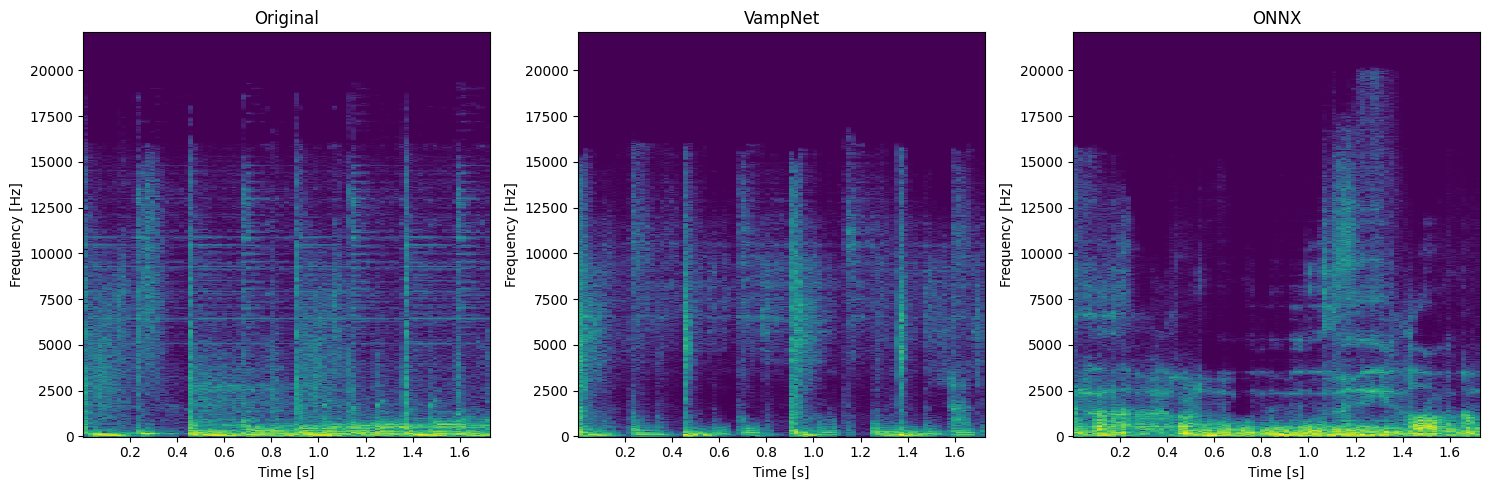

Saved spectrograms to ../outputs/comparison_prepadded/spectrograms.png


In [16]:
# Create spectrograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (audio, title) in enumerate([
    (test_audio_save[:min_len], "Original"),
    (vampnet_audio_save[:min_len], "VampNet"),
    (onnx_audio_save[:min_len], "ONNX")
]):
    f, t, Sxx = signal.spectrogram(audio, sample_rate, nperseg=1024)
    axes[idx].pcolormesh(t, f[:1000], 10 * np.log10(Sxx[:1000] + 1e-10))
    axes[idx].set_title(title)
    axes[idx].set_ylabel('Frequency [Hz]')
    axes[idx].set_xlabel('Time [s]')

plt.tight_layout()
plt.savefig(output_dir / "spectrograms.png", dpi=150)
plt.show()

print(f"Saved spectrograms to {output_dir}/spectrograms.png")

## 15. Summary

In [17]:
# Summary
print("="*60)
print("COMPARISON SUMMARY")
print("="*60)

print(f"\nKey Results:")
print(f"  Token match rate: {match_rate:.1f}%")
print(f"  VampNet time: {vampnet_time:.2f}s")
print(f"  ONNX time: {onnx_total_time:.2f}s (speedup: {vampnet_time/onnx_total_time:.1f}x)")

print(f"\nONNX Limitations:")
print(f"  - Fixed sequence length: {seq_len} tokens")
print(f"  - Maximum audio duration: ~{seq_len * 768 / sample_rate:.1f}s")

print(f"\nFiles saved to: {output_dir}")
print(f"  - 01_original.wav")
print(f"  - 02_vampnet.wav") 
print(f"  - 03_onnx.wav")
print(f"  - spectrograms.png")

print("\n" + "="*60)

COMPARISON SUMMARY

Key Results:
  Token match rate: 95.8%
  VampNet time: 14.34s
  ONNX time: 2.41s (speedup: 6.0x)

ONNX Limitations:
  - Fixed sequence length: 100 tokens
  - Maximum audio duration: ~1.7s

Files saved to: ../outputs/comparison_prepadded
  - 01_original.wav
  - 02_vampnet.wav
  - 03_onnx.wav
  - spectrograms.png

